# A transformer-based model based on "What does self-attention learn from Masked Language Modelling?" paper

### Outline
1. Vanilla attention implementation
2. Factored attention implementation


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F
import seaborn as sns
import sys
sys.path.append('/Users/mariayuffa/semester-project-II')

from utils import *
from models import *

In [2]:
# Sequences for decoder

#dec_train_chains = np.load('data/data_dec_example_big.npy')
#J = np.load("data/contact_mat/J_enc_big.npy")

dec_train_chains = np.load('data/train_example_new.npy')
J = np.load('data/contact_mat/J_example_new.npy')


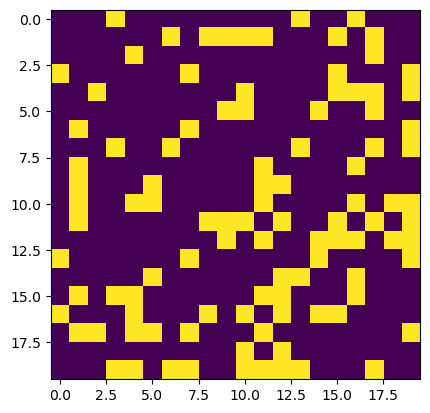

In [3]:
plt.figure()
plt.imshow(J)

In [4]:
#J_large = np.load("data/contact_mat/J_large.npy")
#dec_samples = np.load("data/train_large.npy")
#dec_samples = (dec_samples+1)/2
#print(dec_samples.shape)

In [5]:
batch_size = 32
train_loader = create_dataloaders(dec_train_chains, batch_size)

In [6]:
def train(model, train_loader, vocab, optimizer, criterion, num_epochs=300, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        attention_weights = []
        
        for i, data in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=1):
            # Get the inputs
            #input_one_hot = one_hot_encoding_batch(data, vocab)
            optimizer.zero_grad()
            data_flat = data.flatten()
            data_flat = torch.Tensor([vocab[token.item()] for token in data_flat])
            data = torch.tensor(data_flat).reshape(data.shape[0], data.shape[1]).long()
            
            #mask one token in each sequence and return the masked sequence and the position of the masked token from scratch
            positions = torch.randint(0, data.shape[1], (data.shape[0], 1))
            masked_sequence = data.clone()
            masked_sequence[torch.arange(data.shape[0]), positions.squeeze(-1)] = 2
            masked_sequence = masked_sequence.long()
            # Forward pass
            prediction, scores = model.forward(masked_sequence) #masked_sequence[masked_position]
            #predicted_token = F.log_softmax(prediction, dim=-1)
            positions = positions.squeeze(-1)
            # Compute loss
            loss = criterion(prediction[torch.arange(data.shape[0]), positions], data[torch.arange(data.shape[0]), positions])
            epoch_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            attention_weights.append(scores.detach().cpu().numpy())
            
            running_loss += loss.item()
            #if i % 10 == 9. :    # print every 10 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            #    running_loss = 0.0

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(train_loader)):.4f}')
        #eval_loss = evaluate(model, test_loader, vocab, criterion, device=device)
        #print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss):.4f}')
        
        # Perform early stopping based on eval loss
       #if eval_loss < best_eval_loss:
       #     return epoch_loss / len(train_loader)
    return epoch_loss / len(train_loader), attention_weights


In [14]:
# Define the parameters 
vocab_size = 3
vocab = {0:0,-1:0,1:1,2:2} 
L = 20
embedding_dim = 100
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-3
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [15]:
# Example usage:
a = 0
num_epochs=300
model = VanillaAttentionTransformer(embed_dim=embedding_dim, a=a, max_seq_length=L, num_spins=3, dropout_rate=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss, attn_weights = train(model, train_loader, vocab, optimizer, criterion, num_epochs=num_epochs, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)

  0%|          | 0/300 [00:00<?, ?it/s]/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_11575/3610731036.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data_flat).reshape(data.shape[0], data.shape[1]).long()
  0%|          | 1/300 [00:00<00:33,  9.04it/s]

Epoch 1 | Train Loss: 0.6241


Epoch 2 | Train Loss: 0.6123


  1%|          | 3/300 [00:00<00:30,  9.79it/s]

Epoch 3 | Train Loss: 0.6089


Epoch 4 | Train Loss: 0.6034


  2%|▏         | 5/300 [00:00<00:29, 10.01it/s]

Epoch 5 | Train Loss: 0.6054


  2%|▏         | 6/300 [00:00<00:29,  9.83it/s]

Epoch 6 | Train Loss: 0.5968


  2%|▏         | 7/300 [00:00<00:32,  8.92it/s]

Epoch 7 | Train Loss: 0.5784


  3%|▎         | 8/300 [00:00<00:32,  8.96it/s]

Epoch 8 | Train Loss: 0.5760


  3%|▎         | 9/300 [00:00<00:32,  9.08it/s]

Epoch 9 | Train Loss: 0.5983


  3%|▎         | 10/300 [00:01<00:31,  9.15it/s]

Epoch 10 | Train Loss: 0.5980


  4%|▎         | 11/300 [00:01<00:30,  9.35it/s]

Epoch 11 | Train Loss: 0.5611


  4%|▍         | 12/300 [00:01<00:30,  9.30it/s]

Epoch 12 | Train Loss: 0.5847


  4%|▍         | 13/300 [00:01<00:30,  9.27it/s]

Epoch 13 | Train Loss: 0.5838


  5%|▍         | 14/300 [00:01<00:30,  9.27it/s]

Epoch 14 | Train Loss: 0.5959


  5%|▌         | 15/300 [00:01<00:31,  9.15it/s]

Epoch 15 | Train Loss: 0.6060


  5%|▌         | 16/300 [00:01<00:30,  9.26it/s]

Epoch 16 | Train Loss: 0.5975


  6%|▌         | 17/300 [00:01<00:30,  9.31it/s]

Epoch 17 | Train Loss: 0.5819


  6%|▌         | 18/300 [00:01<00:29,  9.49it/s]

Epoch 18 | Train Loss: 0.5703


  6%|▋         | 19/300 [00:02<00:30,  9.31it/s]

Epoch 19 | Train Loss: 0.6065


  7%|▋         | 20/300 [00:02<00:30,  9.18it/s]

Epoch 20 | Train Loss: 0.5887


  7%|▋         | 21/300 [00:02<00:30,  9.23it/s]

Epoch 21 | Train Loss: 0.5665


  7%|▋         | 22/300 [00:02<00:29,  9.28it/s]

Epoch 22 | Train Loss: 0.5752


  8%|▊         | 23/300 [00:02<00:29,  9.33it/s]

Epoch 23 | Train Loss: 0.5744


Epoch 24 | Train Loss: 0.5483


  8%|▊         | 25/300 [00:02<00:28,  9.65it/s]

Epoch 25 | Train Loss: 0.5532


Epoch 26 | Train Loss: 0.5854


  9%|▉         | 27/300 [00:02<00:27, 10.05it/s]

Epoch 27 | Train Loss: 0.5903


Epoch 28 | Train Loss: 0.5964


 10%|▉         | 29/300 [00:03<00:26, 10.09it/s]

Epoch 29 | Train Loss: 0.5757


Epoch 30 | Train Loss: 0.5720


 10%|█         | 31/300 [00:03<00:26, 10.24it/s]

Epoch 31 | Train Loss: 0.5548


Epoch 32 | Train Loss: 0.5658


 11%|█         | 33/300 [00:03<00:27,  9.83it/s]

Epoch 33 | Train Loss: 0.5619


 11%|█▏        | 34/300 [00:03<00:27,  9.64it/s]

Epoch 34 | Train Loss: 0.5727


Epoch 35 | Train Loss: 0.6045


 12%|█▏        | 36/300 [00:03<00:27,  9.61it/s]

Epoch 36 | Train Loss: 0.5762


 12%|█▏        | 37/300 [00:03<00:27,  9.41it/s]

Epoch 37 | Train Loss: 0.5997


 13%|█▎        | 38/300 [00:04<00:28,  9.19it/s]

Epoch 38 | Train Loss: 0.5685


 13%|█▎        | 39/300 [00:04<00:31,  8.28it/s]

Epoch 39 | Train Loss: 0.5799


 13%|█▎        | 40/300 [00:04<00:31,  8.33it/s]

Epoch 40 | Train Loss: 0.5793


 14%|█▎        | 41/300 [00:04<00:30,  8.59it/s]

Epoch 41 | Train Loss: 0.5908


Epoch 42 | Train Loss: 0.5587


 14%|█▍        | 43/300 [00:04<00:27,  9.18it/s]

Epoch 43 | Train Loss: 0.5629


 15%|█▍        | 44/300 [00:04<00:28,  8.87it/s]

Epoch 44 | Train Loss: 0.5607


 15%|█▌        | 45/300 [00:04<00:30,  8.27it/s]

Epoch 45 | Train Loss: 0.5779


 15%|█▌        | 46/300 [00:04<00:30,  8.36it/s]

Epoch 46 | Train Loss: 0.5738


 16%|█▌        | 47/300 [00:05<00:29,  8.49it/s]

Epoch 47 | Train Loss: 0.5728


 16%|█▌        | 48/300 [00:05<00:30,  8.37it/s]

Epoch 48 | Train Loss: 0.5643


 16%|█▋        | 49/300 [00:05<00:30,  8.35it/s]

Epoch 49 | Train Loss: 0.5580


 17%|█▋        | 50/300 [00:05<00:32,  7.74it/s]

Epoch 50 | Train Loss: 0.5930


 17%|█▋        | 51/300 [00:05<00:31,  7.93it/s]

Epoch 51 | Train Loss: 0.5526


 17%|█▋        | 52/300 [00:05<00:30,  8.24it/s]

Epoch 52 | Train Loss: 0.5694


 18%|█▊        | 53/300 [00:05<00:29,  8.48it/s]

Epoch 53 | Train Loss: 0.5752


 18%|█▊        | 54/300 [00:05<00:28,  8.64it/s]

Epoch 54 | Train Loss: 0.5822


 18%|█▊        | 55/300 [00:06<00:27,  8.79it/s]

Epoch 55 | Train Loss: 0.5443


 19%|█▊        | 56/300 [00:06<00:27,  8.97it/s]

Epoch 56 | Train Loss: 0.5583


 19%|█▉        | 57/300 [00:06<00:26,  9.21it/s]

Epoch 57 | Train Loss: 0.5578


 19%|█▉        | 58/300 [00:06<00:26,  9.28it/s]

Epoch 58 | Train Loss: 0.5950


Epoch 59 | Train Loss: 0.5578


 20%|██        | 60/300 [00:06<00:24,  9.74it/s]

Epoch 60 | Train Loss: 0.5915


 20%|██        | 61/300 [00:06<00:24,  9.79it/s]

Epoch 61 | Train Loss: 0.5544


 21%|██        | 62/300 [00:06<00:24,  9.76it/s]

Epoch 62 | Train Loss: 0.5646


 21%|██        | 63/300 [00:06<00:24,  9.61it/s]

Epoch 63 | Train Loss: 0.5809


 21%|██▏       | 64/300 [00:07<00:26,  8.75it/s]

Epoch 64 | Train Loss: 0.5674


 22%|██▏       | 65/300 [00:07<00:28,  8.31it/s]

Epoch 65 | Train Loss: 0.5647


 22%|██▏       | 66/300 [00:07<00:27,  8.59it/s]

Epoch 66 | Train Loss: 0.5808


Epoch 67 | Train Loss: 0.5791


 23%|██▎       | 68/300 [00:07<00:25,  9.22it/s]

Epoch 68 | Train Loss: 0.5627


 23%|██▎       | 69/300 [00:07<00:24,  9.38it/s]

Epoch 69 | Train Loss: 0.5584


 23%|██▎       | 70/300 [00:07<00:24,  9.49it/s]

Epoch 70 | Train Loss: 0.5609


 24%|██▎       | 71/300 [00:07<00:23,  9.56it/s]

Epoch 71 | Train Loss: 0.5472


 24%|██▍       | 72/300 [00:07<00:24,  9.38it/s]

Epoch 72 | Train Loss: 0.5815


 24%|██▍       | 73/300 [00:07<00:24,  9.19it/s]

Epoch 73 | Train Loss: 0.5589


 25%|██▍       | 74/300 [00:08<00:24,  9.10it/s]

Epoch 74 | Train Loss: 0.5608


 25%|██▌       | 75/300 [00:08<00:24,  9.32it/s]

Epoch 75 | Train Loss: 0.5476


 25%|██▌       | 76/300 [00:08<00:23,  9.35it/s]

Epoch 76 | Train Loss: 0.5480


 26%|██▌       | 77/300 [00:08<00:23,  9.53it/s]

Epoch 77 | Train Loss: 0.5903


 26%|██▌       | 78/300 [00:08<00:23,  9.55it/s]

Epoch 78 | Train Loss: 0.5955


 26%|██▋       | 79/300 [00:08<00:26,  8.44it/s]

Epoch 79 | Train Loss: 0.5590


 27%|██▋       | 80/300 [00:08<00:25,  8.55it/s]

Epoch 80 | Train Loss: 0.5646


 27%|██▋       | 81/300 [00:08<00:25,  8.54it/s]

Epoch 81 | Train Loss: 0.5776


 27%|██▋       | 82/300 [00:08<00:24,  8.87it/s]

Epoch 82 | Train Loss: 0.5688


 28%|██▊       | 83/300 [00:09<00:26,  8.31it/s]

Epoch 83 | Train Loss: 0.5936


Epoch 84 | Train Loss: 0.5949


 28%|██▊       | 85/300 [00:09<00:23,  8.97it/s]

Epoch 85 | Train Loss: 0.5777


Epoch 86 | Train Loss: 0.5937


 29%|██▉       | 87/300 [00:09<00:22,  9.35it/s]

Epoch 87 | Train Loss: 0.5624


 29%|██▉       | 88/300 [00:09<00:22,  9.35it/s]

Epoch 88 | Train Loss: 0.5733


Epoch 89 | Train Loss: 0.5786


 30%|███       | 90/300 [00:09<00:21,  9.64it/s]

Epoch 90 | Train Loss: 0.5839


 30%|███       | 91/300 [00:09<00:21,  9.69it/s]

Epoch 91 | Train Loss: 0.5566


 31%|███       | 92/300 [00:10<00:21,  9.63it/s]

Epoch 92 | Train Loss: 0.5585


 31%|███       | 93/300 [00:10<00:21,  9.65it/s]

Epoch 93 | Train Loss: 0.5797


 31%|███▏      | 94/300 [00:10<00:23,  8.81it/s]

Epoch 94 | Train Loss: 0.5515


 32%|███▏      | 95/300 [00:10<00:22,  8.95it/s]

Epoch 95 | Train Loss: 0.5710


 32%|███▏      | 96/300 [00:10<00:22,  9.05it/s]

Epoch 96 | Train Loss: 0.5816


 32%|███▏      | 97/300 [00:10<00:22,  9.10it/s]

Epoch 97 | Train Loss: 0.6042


Epoch 98 | Train Loss: 0.5684


 33%|███▎      | 99/300 [00:10<00:21,  9.54it/s]

Epoch 99 | Train Loss: 0.5568


Epoch 100 | Train Loss: 0.5839


 34%|███▎      | 101/300 [00:11<00:20,  9.66it/s]

Epoch 101 | Train Loss: 0.5604


 34%|███▍      | 102/300 [00:11<00:21,  9.17it/s]

Epoch 102 | Train Loss: 0.5766


 34%|███▍      | 103/300 [00:11<00:21,  9.17it/s]

Epoch 103 | Train Loss: 0.5734


 35%|███▍      | 104/300 [00:11<00:21,  9.32it/s]

Epoch 104 | Train Loss: 0.5479


 35%|███▌      | 105/300 [00:11<00:20,  9.38it/s]

Epoch 105 | Train Loss: 0.5553


 35%|███▌      | 106/300 [00:11<00:20,  9.34it/s]

Epoch 106 | Train Loss: 0.5918


Epoch 107 | Train Loss: 0.5635


 36%|███▌      | 108/300 [00:11<00:19,  9.66it/s]

Epoch 108 | Train Loss: 0.5732


 36%|███▋      | 109/300 [00:11<00:21,  9.01it/s]

Epoch 109 | Train Loss: 0.5781


 37%|███▋      | 110/300 [00:12<00:21,  8.71it/s]

Epoch 110 | Train Loss: 0.5845


 37%|███▋      | 111/300 [00:12<00:23,  8.21it/s]

Epoch 111 | Train Loss: 0.5731


 37%|███▋      | 112/300 [00:12<00:23,  8.12it/s]

Epoch 112 | Train Loss: 0.5839


 38%|███▊      | 113/300 [00:12<00:22,  8.27it/s]

Epoch 113 | Train Loss: 0.5636


 38%|███▊      | 114/300 [00:12<00:21,  8.64it/s]

Epoch 114 | Train Loss: 0.5553


Epoch 115 | Train Loss: 0.5727


 39%|███▊      | 116/300 [00:12<00:19,  9.21it/s]

Epoch 116 | Train Loss: 0.5837


 39%|███▉      | 117/300 [00:12<00:20,  8.83it/s]

Epoch 117 | Train Loss: 0.5664


Epoch 118 | Train Loss: 0.5759


 40%|███▉      | 119/300 [00:13<00:19,  9.34it/s]

Epoch 119 | Train Loss: 0.5847


Epoch 120 | Train Loss: 0.5585


 40%|████      | 121/300 [00:13<00:18,  9.66it/s]

Epoch 121 | Train Loss: 0.5737


 41%|████      | 122/300 [00:13<00:19,  9.06it/s]

Epoch 122 | Train Loss: 0.5866


Epoch 123 | Train Loss: 0.5759


 41%|████▏     | 124/300 [00:13<00:18,  9.48it/s]

Epoch 124 | Train Loss: 0.5714


Epoch 125 | Train Loss: 0.5741


 42%|████▏     | 126/300 [00:13<00:17,  9.80it/s]

Epoch 126 | Train Loss: 0.5683


Epoch 127 | Train Loss: 0.5822


 43%|████▎     | 128/300 [00:13<00:17,  9.96it/s]

Epoch 128 | Train Loss: 0.5735


Epoch 129 | Train Loss: 0.5725


 43%|████▎     | 130/300 [00:14<00:16, 10.02it/s]

Epoch 130 | Train Loss: 0.5757


Epoch 131 | Train Loss: 0.5721


 44%|████▍     | 132/300 [00:14<00:16, 10.19it/s]

Epoch 132 | Train Loss: 0.5600


Epoch 133 | Train Loss: 0.5461


 45%|████▍     | 134/300 [00:14<00:16, 10.05it/s]

Epoch 134 | Train Loss: 0.5956


Epoch 135 | Train Loss: 0.5905


 45%|████▌     | 136/300 [00:14<00:16, 10.00it/s]

Epoch 136 | Train Loss: 0.5472


 46%|████▌     | 137/300 [00:14<00:17,  9.34it/s]

Epoch 137 | Train Loss: 0.5671


 46%|████▌     | 138/300 [00:14<00:17,  9.46it/s]

Epoch 138 | Train Loss: 0.5801


 46%|████▋     | 139/300 [00:15<00:17,  9.16it/s]

Epoch 139 | Train Loss: 0.5657


Epoch 140 | Train Loss: 0.5736


 47%|████▋     | 141/300 [00:15<00:16,  9.53it/s]

Epoch 141 | Train Loss: 0.5726


 47%|████▋     | 142/300 [00:15<00:16,  9.61it/s]

Epoch 142 | Train Loss: 0.5410


Epoch 143 | Train Loss: 0.5729


 48%|████▊     | 144/300 [00:15<00:15,  9.81it/s]

Epoch 144 | Train Loss: 0.5538


Epoch 145 | Train Loss: 0.5795


 49%|████▊     | 146/300 [00:15<00:15,  9.98it/s]

Epoch 146 | Train Loss: 0.5606


 49%|████▉     | 147/300 [00:15<00:15,  9.95it/s]

Epoch 147 | Train Loss: 0.5562


 49%|████▉     | 148/300 [00:15<00:15,  9.91it/s]

Epoch 148 | Train Loss: 0.5734


Epoch 149 | Train Loss: 0.5513


 50%|█████     | 150/300 [00:16<00:14, 10.03it/s]

Epoch 150 | Train Loss: 0.5639


 50%|█████     | 151/300 [00:16<00:16,  9.29it/s]

Epoch 151 | Train Loss: 0.5603


Epoch 152 | Train Loss: 0.5429


 51%|█████     | 153/300 [00:16<00:15,  9.60it/s]

Epoch 153 | Train Loss: 0.5561


 51%|█████▏    | 154/300 [00:16<00:15,  9.63it/s]

Epoch 154 | Train Loss: 0.5904


 52%|█████▏    | 155/300 [00:16<00:15,  9.53it/s]

Epoch 155 | Train Loss: 0.5593


Epoch 156 | Train Loss: 0.5624


 52%|█████▏    | 157/300 [00:16<00:14,  9.72it/s]

Epoch 157 | Train Loss: 0.5841


 53%|█████▎    | 158/300 [00:17<00:14,  9.78it/s]

Epoch 158 | Train Loss: 0.5658


Epoch 159 | Train Loss: 0.5737


 53%|█████▎    | 160/300 [00:17<00:14,  9.39it/s]

Epoch 160 | Train Loss: 0.5513


Epoch 161 | Train Loss: 0.5675


 54%|█████▍    | 162/300 [00:17<00:14,  9.73it/s]

Epoch 162 | Train Loss: 0.5727


Epoch 163 | Train Loss: 0.5628


 55%|█████▍    | 164/300 [00:17<00:13,  9.81it/s]

Epoch 164 | Train Loss: 0.5578


 55%|█████▌    | 165/300 [00:17<00:14,  9.25it/s]

Epoch 165 | Train Loss: 0.5757


 55%|█████▌    | 166/300 [00:17<00:14,  9.36it/s]

Epoch 166 | Train Loss: 0.5749


 56%|█████▌    | 167/300 [00:17<00:14,  9.49it/s]

Epoch 167 | Train Loss: 0.5640


Epoch 168 | Train Loss: 0.5472


 56%|█████▋    | 169/300 [00:18<00:13,  9.77it/s]

Epoch 169 | Train Loss: 0.5652


Epoch 170 | Train Loss: 0.5343


 57%|█████▋    | 171/300 [00:18<00:12,  9.95it/s]

Epoch 171 | Train Loss: 0.5556


Epoch 172 | Train Loss: 0.5628


 58%|█████▊    | 173/300 [00:18<00:12, 10.08it/s]

Epoch 173 | Train Loss: 0.5753


Epoch 174 | Train Loss: 0.5329


 58%|█████▊    | 175/300 [00:18<00:12, 10.10it/s]

Epoch 175 | Train Loss: 0.5483


Epoch 176 | Train Loss: 0.5698


 59%|█████▉    | 177/300 [00:18<00:12, 10.16it/s]

Epoch 177 | Train Loss: 0.5650


Epoch 178 | Train Loss: 0.5555


 60%|█████▉    | 179/300 [00:19<00:12,  9.42it/s]

Epoch 179 | Train Loss: 0.5594


Epoch 180 | Train Loss: 0.5817


 60%|██████    | 181/300 [00:19<00:12,  9.53it/s]

Epoch 181 | Train Loss: 0.5310


 61%|██████    | 182/300 [00:19<00:12,  9.61it/s]

Epoch 182 | Train Loss: 0.5625


 61%|██████    | 183/300 [00:19<00:12,  9.52it/s]

Epoch 183 | Train Loss: 0.5691


 61%|██████▏   | 184/300 [00:19<00:12,  9.06it/s]

Epoch 184 | Train Loss: 0.5518


Epoch 185 | Train Loss: 0.5657


 62%|██████▏   | 186/300 [00:19<00:12,  9.46it/s]

Epoch 186 | Train Loss: 0.5511


 62%|██████▏   | 187/300 [00:20<00:11,  9.57it/s]

Epoch 187 | Train Loss: 0.5369


Epoch 188 | Train Loss: 0.5378


 63%|██████▎   | 189/300 [00:20<00:11,  9.88it/s]

Epoch 189 | Train Loss: 0.5654


Epoch 190 | Train Loss: 0.5370


 64%|██████▎   | 191/300 [00:20<00:10, 10.00it/s]

Epoch 191 | Train Loss: 0.5636


Epoch 192 | Train Loss: 0.5657


 64%|██████▍   | 193/300 [00:20<00:11,  9.50it/s]

Epoch 193 | Train Loss: 0.5700


Epoch 194 | Train Loss: 0.5659


 65%|██████▌   | 195/300 [00:20<00:10,  9.75it/s]

Epoch 195 | Train Loss: 0.5547


 65%|██████▌   | 196/300 [00:20<00:10,  9.78it/s]

Epoch 196 | Train Loss: 0.5485


 66%|██████▌   | 197/300 [00:21<00:10,  9.81it/s]

Epoch 197 | Train Loss: 0.5532


Epoch 198 | Train Loss: 0.5527


 66%|██████▋   | 199/300 [00:21<00:10,  9.96it/s]

Epoch 199 | Train Loss: 0.5531


Epoch 200 | Train Loss: 0.5708


 67%|██████▋   | 201/300 [00:21<00:09, 10.02it/s]

Epoch 201 | Train Loss: 0.5517


Epoch 202 | Train Loss: 0.5891


 68%|██████▊   | 203/300 [00:21<00:09,  9.74it/s]

Epoch 203 | Train Loss: 0.5653


 68%|██████▊   | 204/300 [00:21<00:10,  9.27it/s]

Epoch 204 | Train Loss: 0.5350


 68%|██████▊   | 205/300 [00:21<00:10,  9.01it/s]

Epoch 205 | Train Loss: 0.5520


 69%|██████▊   | 206/300 [00:22<00:10,  8.99it/s]

Epoch 206 | Train Loss: 0.5620


 69%|██████▉   | 207/300 [00:22<00:11,  8.12it/s]

Epoch 207 | Train Loss: 0.5666


 69%|██████▉   | 208/300 [00:22<00:10,  8.36it/s]

Epoch 208 | Train Loss: 0.5609


 70%|██████▉   | 209/300 [00:22<00:10,  8.60it/s]

Epoch 209 | Train Loss: 0.5702


 70%|███████   | 210/300 [00:22<00:10,  8.79it/s]

Epoch 210 | Train Loss: 0.5694


 70%|███████   | 211/300 [00:22<00:10,  8.36it/s]

Epoch 211 | Train Loss: 0.5756


 71%|███████   | 212/300 [00:22<00:10,  8.38it/s]

Epoch 212 | Train Loss: 0.5480


 71%|███████   | 213/300 [00:22<00:10,  8.46it/s]

Epoch 213 | Train Loss: 0.5776


 71%|███████▏  | 214/300 [00:23<00:10,  8.42it/s]

Epoch 214 | Train Loss: 0.5376


 72%|███████▏  | 215/300 [00:23<00:09,  8.64it/s]

Epoch 215 | Train Loss: 0.5405


 72%|███████▏  | 216/300 [00:23<00:09,  8.89it/s]

Epoch 216 | Train Loss: 0.5642


 72%|███████▏  | 217/300 [00:23<00:09,  8.88it/s]

Epoch 217 | Train Loss: 0.5814


 73%|███████▎  | 218/300 [00:23<00:09,  8.93it/s]

Epoch 218 | Train Loss: 0.5587


 73%|███████▎  | 219/300 [00:23<00:09,  8.99it/s]

Epoch 219 | Train Loss: 0.5604


 73%|███████▎  | 220/300 [00:23<00:08,  9.25it/s]

Epoch 220 | Train Loss: 0.5737


 74%|███████▎  | 221/300 [00:23<00:09,  8.32it/s]

Epoch 221 | Train Loss: 0.5529


 74%|███████▍  | 222/300 [00:23<00:09,  8.41it/s]

Epoch 222 | Train Loss: 0.5662


 74%|███████▍  | 223/300 [00:24<00:09,  8.50it/s]

Epoch 223 | Train Loss: 0.5411


 75%|███████▍  | 224/300 [00:24<00:08,  8.61it/s]

Epoch 224 | Train Loss: 0.5671


 75%|███████▌  | 225/300 [00:24<00:08,  8.78it/s]

Epoch 225 | Train Loss: 0.5509


 75%|███████▌  | 226/300 [00:24<00:08,  8.84it/s]

Epoch 226 | Train Loss: 0.5685


 76%|███████▌  | 227/300 [00:24<00:08,  8.63it/s]

Epoch 227 | Train Loss: 0.5613


 76%|███████▌  | 228/300 [00:24<00:08,  8.72it/s]

Epoch 228 | Train Loss: 0.5624


 76%|███████▋  | 229/300 [00:24<00:08,  8.84it/s]

Epoch 229 | Train Loss: 0.5557


 77%|███████▋  | 230/300 [00:24<00:07,  8.85it/s]

Epoch 230 | Train Loss: 0.5784


 77%|███████▋  | 231/300 [00:24<00:07,  8.94it/s]

Epoch 231 | Train Loss: 0.5630


 77%|███████▋  | 232/300 [00:25<00:07,  8.93it/s]

Epoch 232 | Train Loss: 0.5477


 78%|███████▊  | 233/300 [00:25<00:07,  8.98it/s]

Epoch 233 | Train Loss: 0.5353


 78%|███████▊  | 234/300 [00:25<00:07,  8.94it/s]

Epoch 234 | Train Loss: 0.5517


 78%|███████▊  | 235/300 [00:25<00:07,  8.15it/s]

Epoch 235 | Train Loss: 0.5737


 79%|███████▊  | 236/300 [00:25<00:08,  7.92it/s]

Epoch 236 | Train Loss: 0.5529


 79%|███████▉  | 237/300 [00:25<00:07,  8.11it/s]

Epoch 237 | Train Loss: 0.5743


 79%|███████▉  | 238/300 [00:25<00:07,  8.08it/s]

Epoch 238 | Train Loss: 0.5561


 80%|███████▉  | 239/300 [00:25<00:07,  8.16it/s]

Epoch 239 | Train Loss: 0.5761


 80%|████████  | 240/300 [00:26<00:07,  8.28it/s]

Epoch 240 | Train Loss: 0.5579


 80%|████████  | 241/300 [00:26<00:07,  8.38it/s]

Epoch 241 | Train Loss: 0.5758


 81%|████████  | 242/300 [00:26<00:06,  8.30it/s]

Epoch 242 | Train Loss: 0.5331


 81%|████████  | 243/300 [00:26<00:06,  8.22it/s]

Epoch 243 | Train Loss: 0.5467


 81%|████████▏ | 244/300 [00:26<00:07,  7.79it/s]

Epoch 244 | Train Loss: 0.5397


 82%|████████▏ | 245/300 [00:26<00:06,  8.31it/s]

Epoch 245 | Train Loss: 0.5408


 82%|████████▏ | 246/300 [00:26<00:07,  7.21it/s]

Epoch 246 | Train Loss: 0.5526


 82%|████████▏ | 247/300 [00:26<00:07,  7.55it/s]

Epoch 247 | Train Loss: 0.5434


 83%|████████▎ | 248/300 [00:27<00:06,  7.89it/s]

Epoch 248 | Train Loss: 0.5451


 83%|████████▎ | 249/300 [00:27<00:06,  8.19it/s]

Epoch 249 | Train Loss: 0.5487


 83%|████████▎ | 250/300 [00:27<00:05,  8.41it/s]

Epoch 250 | Train Loss: 0.5672


 84%|████████▎ | 251/300 [00:27<00:05,  8.73it/s]

Epoch 251 | Train Loss: 0.5524


Epoch 252 | Train Loss: 0.5686


 84%|████████▍ | 253/300 [00:27<00:04,  9.44it/s]

Epoch 253 | Train Loss: 0.5726


 85%|████████▍ | 254/300 [00:27<00:04,  9.53it/s]

Epoch 254 | Train Loss: 0.5642


 85%|████████▌ | 255/300 [00:27<00:04,  9.31it/s]

Epoch 255 | Train Loss: 0.5820


 85%|████████▌ | 256/300 [00:27<00:04,  8.89it/s]

Epoch 256 | Train Loss: 0.5785


Epoch 257 | Train Loss: 0.5542


 86%|████████▌ | 258/300 [00:28<00:04,  9.16it/s]

Epoch 258 | Train Loss: 0.5383


 86%|████████▋ | 259/300 [00:28<00:04,  9.10it/s]

Epoch 259 | Train Loss: 0.5495


 87%|████████▋ | 260/300 [00:28<00:04,  9.28it/s]

Epoch 260 | Train Loss: 0.5553


 87%|████████▋ | 261/300 [00:28<00:04,  9.28it/s]

Epoch 261 | Train Loss: 0.5434


 87%|████████▋ | 262/300 [00:28<00:04,  9.20it/s]

Epoch 262 | Train Loss: 0.5413


 88%|████████▊ | 263/300 [00:28<00:04,  8.92it/s]

Epoch 263 | Train Loss: 0.5723


 88%|████████▊ | 264/300 [00:28<00:03,  9.02it/s]

Epoch 264 | Train Loss: 0.5338


 88%|████████▊ | 265/300 [00:28<00:03,  9.26it/s]

Epoch 265 | Train Loss: 0.5594


 89%|████████▊ | 266/300 [00:29<00:04,  8.48it/s]

Epoch 266 | Train Loss: 0.5587


 89%|████████▉ | 267/300 [00:29<00:03,  8.76it/s]

Epoch 267 | Train Loss: 0.5745


 89%|████████▉ | 268/300 [00:29<00:03,  8.69it/s]

Epoch 268 | Train Loss: 0.5458


 90%|████████▉ | 269/300 [00:29<00:03,  8.87it/s]

Epoch 269 | Train Loss: 0.5646


Epoch 270 | Train Loss: 0.5632


 90%|█████████ | 271/300 [00:29<00:03,  8.86it/s]

Epoch 271 | Train Loss: 0.5661


 91%|█████████ | 272/300 [00:29<00:03,  9.10it/s]

Epoch 272 | Train Loss: 0.5577


 91%|█████████ | 273/300 [00:29<00:03,  8.91it/s]

Epoch 273 | Train Loss: 0.5679


Epoch 274 | Train Loss: 0.5585


 92%|█████████▏| 275/300 [00:29<00:02,  9.59it/s]

Epoch 275 | Train Loss: 0.5432


Epoch 276 | Train Loss: 0.5829


 92%|█████████▏| 277/300 [00:30<00:02,  9.90it/s]

Epoch 277 | Train Loss: 0.5315


 93%|█████████▎| 278/300 [00:30<00:02,  9.89it/s]

Epoch 278 | Train Loss: 0.5650


Epoch 279 | Train Loss: 0.5762


 93%|█████████▎| 280/300 [00:30<00:02,  9.94it/s]

Epoch 280 | Train Loss: 0.6023


Epoch 281 | Train Loss: 0.5408


 94%|█████████▍| 282/300 [00:30<00:01, 10.06it/s]

Epoch 282 | Train Loss: 0.5384


 94%|█████████▍| 283/300 [00:30<00:01, 10.03it/s]

Epoch 283 | Train Loss: 0.5641


Epoch 284 | Train Loss: 0.5437


 95%|█████████▌| 285/300 [00:30<00:01, 10.03it/s]

Epoch 285 | Train Loss: 0.5748


 95%|█████████▌| 286/300 [00:31<00:01, 10.00it/s]

Epoch 286 | Train Loss: 0.5512


 96%|█████████▌| 287/300 [00:31<00:01, 10.00it/s]

Epoch 287 | Train Loss: 0.5619


Epoch 288 | Train Loss: 0.5603


 96%|█████████▋| 289/300 [00:31<00:01,  9.95it/s]

Epoch 289 | Train Loss: 0.5419


Epoch 290 | Train Loss: 0.5453


 97%|█████████▋| 291/300 [00:31<00:00,  9.44it/s]

Epoch 291 | Train Loss: 0.5660


 97%|█████████▋| 292/300 [00:31<00:00,  9.37it/s]

Epoch 292 | Train Loss: 0.5790


 98%|█████████▊| 293/300 [00:31<00:00,  9.48it/s]

Epoch 293 | Train Loss: 0.5645


Epoch 294 | Train Loss: 0.5663


 98%|█████████▊| 295/300 [00:32<00:00,  9.91it/s]

Epoch 295 | Train Loss: 0.5540


Epoch 296 | Train Loss: 0.5536


 99%|█████████▉| 297/300 [00:32<00:00, 10.14it/s]

Epoch 297 | Train Loss: 0.5326


Epoch 298 | Train Loss: 0.5649


100%|█████████▉| 299/300 [00:32<00:00, 10.26it/s]

Epoch 299 | Train Loss: 0.5816


Epoch 300 | Train Loss: 0.5840


Text(0.5, 1.0, 'Attention weights (a=0), TP=0.736')

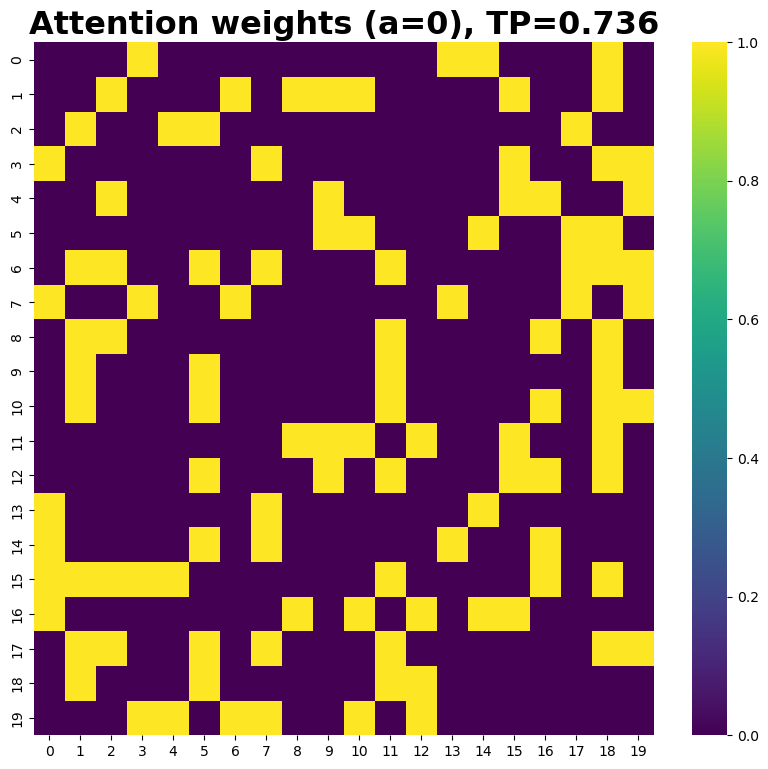

In [19]:
weights = attn_weights[-1].mean(axis=0)
threshold_mi = np.percentile(weights, 70)
weights = np.where(weights > threshold_mi, 1, 0)
np.fill_diagonal(weights, 0)
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
sns.heatmap(weights, ax=ax, cmap='viridis')
ax.set_title(f"Attention weights (a={a}), TP={np.round(calculate_true_positives(weights.flatten(), J.flatten())[1], 3)}", fontweight="bold", size=23)

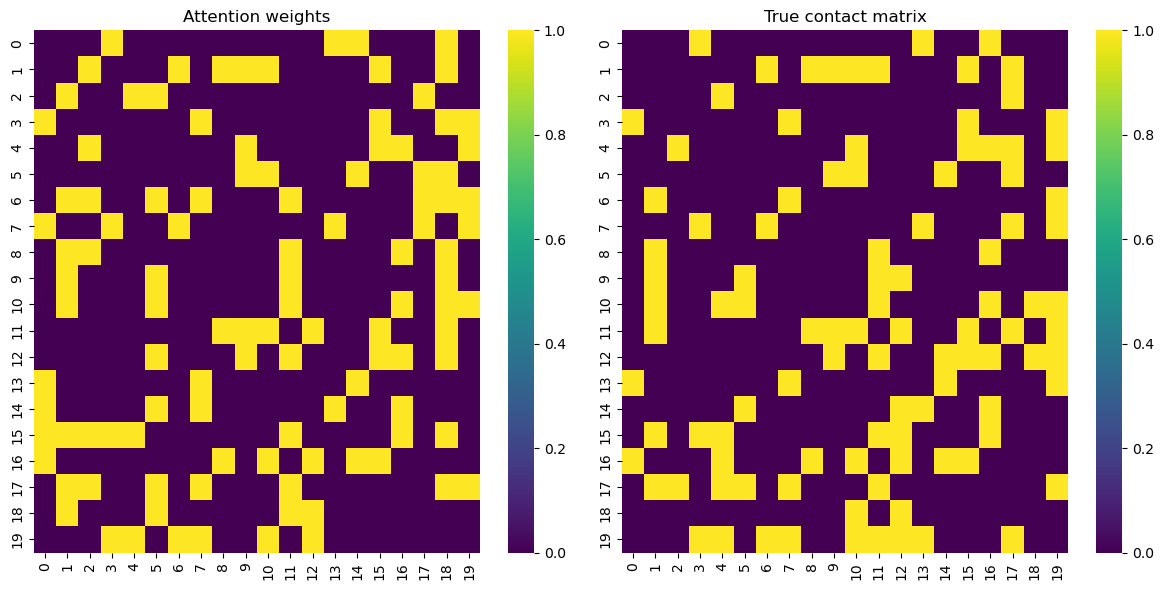

(81, 0.7363636363636363)
(29, 0.09731543624161074)


In [25]:
weights = attn_weights[-1].mean(axis=0)
threshold_mi = np.percentile(weights, 70)
weights = np.where(weights > threshold_mi, 1, 0)
np.fill_diagonal(weights, 0)
plotting_heatmaps(weights, J, "Attention weights", "True contact matrix")
print(calculate_true_positives(weights.flatten(), J.flatten()))
print(calculate_false_positives(weights.flatten(), J.flatten()))